# Particle Filter

In [1]:
# Relevant packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from pykalman import KalmanFilter
plt.style.use('ggplot')

## Prologue: Importance Sampling

$p$ - intractable, target density

$q$ - tractable, deliberately chosen so, where we end up sampling from

$h$ - arbitrary quantity we want to evaluate

Aim: By sampling $x_i$ from $q(x)$, estimate the integral by the unbiased estimator:

$$I=\mathbb{E}_p[h]=\mathbb{E}_q[p/q\cdot h]\approx \frac{1}{M}\sum_{i=1}^{m}h(x_i)\frac{p(x_i)}{q(x_i)}=\hat{I}$$

In [2]:
# w/ normalised p=N(0,1), q=student-t_5, h=x^2
np.random.seed(42)
M=100 # Samples 
df = 5 # degrees of freedom

# Sample x_i from q(x) and calculate p,q,h
x=t.rvs(df=5, size=M)

p_density=norm.pdf(x)
q_density=t.pdf(x,5)
h_quantity=x**2

# Calculate density (actual is 1 since E[x^2]=var(x)+E[x]^2, 
# for N(0,1) this becomes E[x^2]=var(x)+0^2=var(x)=1).
np.mean(h_quantity*(p_density/q_density))

0.9487473302166908

### When we know $p$ up to proportionality

We want to calculate $p(x|y)$ but we only know the prior ($p_{0}(x)$) and likelihood ($f(y|x)$), and not the normalising constant. Note we can write:
$$p_{0}(x)f(y|x)=p(x,y)$$ 
i.e. the conditional probability density function.

The normalising constant is $p(y)$ and can be calculated as:

$$p(y)\approx \frac{1}{M}\sum_{j=1}^{M}\frac{p(x^{(j)},y)}{q(x^{(j)})}\equiv \hat{p}(y)$$

This is an unbiased estimator.

The unormalised weights are then set as, $w_{*}^{(j)}=p(x^{(j)},y)/q(x^{(j)})$. The normalised weights are given by:

$$w^{(i)}=\frac{w_{*}^{(i)}}{\sum_{j=1}^{M}w_{*}^{(j)}}$$

Thus, we have the Integral and normalisation constant calculated as:

$$\hat{I}=\sum_{j=1}^{M}h(x^{(i)})w^{(i)}, \ \ \hat{p}(y)=\frac{1}{M}\sum_{j=1}^{M}w_{*}^{(i)}$$

respectively.

In [3]:
# w/ un-normalised p=N(0,1), q=student-t_5, h=x^2
np.random.seed(42)
M=100

# Sample from q
x=t.rvs(df=5, size=M)

# Calculate weights
w_star=np.exp(-x**2/2)/t.pdf(x,5) # note unoramlised N(0,1) is just e^(-x^2/2)

# Calculate noramlised weights
w=w_star/np.sum(w_star)

h_quantity=x**2

# Calculate I, i.e. E[x^2]
I_est=np.sum(h_quantity*w)

# Calculate the weights (normalising constant)
norm_constant=np.mean(w_star)

# Should be 1 and sqrt(2*pi)=2.506628 approx. respectively
I_est, norm_constant

(0.941144847323871, 2.526876590956301)

## The Bootstrap Filter

Latent Gaussian Model:

$x_t=x_{t-1}+\mathcal{N}(0,1)$, $x_0\sim \mathcal{N}(0,1)$

$y_t=x_t+\mathcal{N}(0,1)$

In [4]:
# latent Gaussian process
np.random.seed(42) # Reproducbility

# Time steps
ts = 100

# Generate data points
x_orig = np.cumsum(norm.rvs(size=ts+1))
y=x_orig+norm.rvs(size=ts+1)

In [5]:
# Kalman Filter for the latent process to check (using premade package)
kf = KalmanFilter(transition_matrices=[1], observation_matrices=[1],transition_covariance=[1], observation_covariance=[1])
kalman,c=kf.filter(y)

In [6]:
def bootstrapFilter(y, ts, resample=True, particles=200):
    
    # Set up
    N=particles 
    w_unnorm=np.empty(N)
    all_weights=[]
    
    # Step 1. Initialise
    x=np.empty((ts+1,N))
    means=np.zeros(ts+1)
    for i in range(N):
        x[0][i]=norm.rvs()
    for t in range(1,ts+1):
        # Step 2. Importance sampling
        for i in range(N):
            x[t][i]=x[t-1][i]+norm.rvs()
        # Calculate importance weights
        for i in range(N):
            w_unnorm[i] = norm.pdf(y[t-1],loc=x[t][i])
        
        # Normalise
        w=w_unnorm/np.sum(w_unnorm)
        all_weights.append(w)
        # Keep track of the mean (for graphical purposes)
        means[t-1]=sum(w*x[t])
        
        if(resample):
            # Step 3. Resampling
            s = np.random.choice(np.array([i for i in range(N)]),size=N, replace=True, p=w)

             # Resample whole path
            for j in range(1,t+1):
                x[j]=x[j][s]
    
    # Calculate the final mean
    means[-1]=sum(w*x[-1])
    
    return(means,all_weights)

In [7]:
# Set up for graph
points=np.linspace(0,ts+1,ts+1)

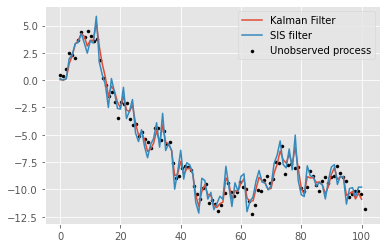

0.3590260511528483
MSE:0.3590260511528483


In [8]:
# SIS filter (no resampling)
np.random.seed(42)
sis, weights_sis=bootstrapFilter(y, ts, resample=False)
plt.scatter(points, x_orig, marker='.', color='black', label='Unobserved process')
plt.plot(kalman, label='Kalman Filter') # Plots the means
plt.plot(sis, label='SIS filter')
plt.legend()
plt.show()

# MSE
difference_array = np.subtract(kalman.T, sis)
squared_array = np.square(difference_array)
mse = squared_array.mean()
print(mse)
print('MSE:' + str(mse))

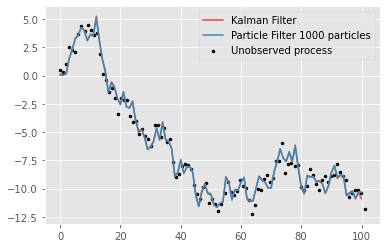

MSE:0.008992012647478096


In [9]:
# Bootstrap Filter
np.random.seed(42)
pf, weights_pf=bootstrapFilter(y,ts)
plt.scatter(points, x_orig, marker='.', color='black', label='Unobserved process')
plt.plot(kalman, label='Kalman Filter') # Plots the means
plt.plot(pf, label='Particle Filter 1000 particles' )
plt.legend()
plt.show()

# MSE
difference_array = np.subtract(kalman.T, pf)
squared_array = np.square(difference_array)
mse = squared_array.mean()
print('MSE:' + str(mse))

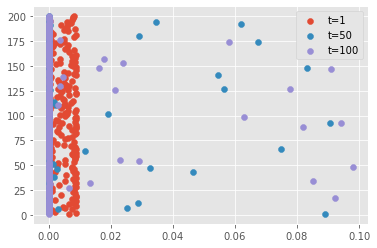

In [10]:
# Weight Distribution SIS

plt.scatter(weights_sis[1], np.linspace(1,200,200), label='t=1')
plt.scatter(weights_sis[50], np.linspace(1,200,200),label='t=50')
plt.scatter(weights_sis[-1], np.linspace(1,200,200), label='t=100')
plt.legend()
plt.legend(framealpha=1, loc=1)
plt.show()

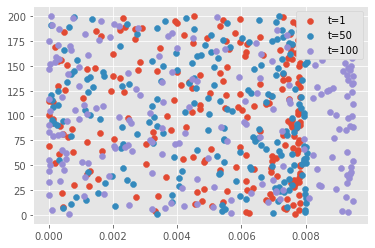

In [11]:
# Weight Distribution PF

plt.scatter(weights_pf[1], np.linspace(1,200,200), label='t=1')
plt.scatter(weights_pf[50], np.linspace(1,200,200), label='t=50')
plt.scatter(weights_pf[-1],np.linspace(1,200,200), label='t=100')
plt.legend(framealpha=1, loc=1)
plt.show()